# Поиск оптимальных точек для складов на карте метро Москвы

In [59]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import re
import pandas as pd

## Создание исходного графа

Данные о переходах

In [68]:
transfers = pd.read_csv('transfers.txt', sep="[=,]+", engine='python', encoding="utf-8")
transfers.head()

,место,линия1,станция1,линия2,станция2,время
0,Китай-город,Таганско-Краснопресненская,Китай-город,Калужско-Рижская,Китай-город,1.0
1,Комсомольская,Сокольническая,Комсомольская,Кольцевая,Комсомольская,5.0
2,Курская1,Арбатско-Покровская,Курская,Кольцевая,Курская,3.0
3,Курская2,Кольцевая,Курская,Люблинско-Дмитровская,Чкаловская,4.0
4,Курская3,Арбатско-Покровская,Курская,Люблинско-Дмитровская,Чкаловская,2.0


Создание списка связанных переходом станций

In [69]:
station_nodes = []
for i, node_part in transfers.iterrows():
    flag = False
    for node in station_nodes:
        if node_part['станция1'] in node:
            flag = True
            node.add(node_part['станция2'])
        elif node_part['станция2'] in node:
            flag = True
            node.add(node_part['станция1'])
    if not flag:
        part_set = set()
        part_set.add(node_part['станция1'])
        part_set.add(node_part['станция2'])
        station_nodes.append(part_set)


Сбор данных о линиях

In [70]:
lines = []
with open('lines.txt', encoding="utf-8") as read_file:
    for line in read_file:
        line = line.strip().replace(';', '')
        if re.search(r'\[Line([\d\.A-z]+)\]', line):
            lines.append({'number':re.search(r'\[Line([\d\.A-z]+)\]', line).group(1)})
        else:
            l_sp = line.split("=")
            if l_sp[0] == 'Name':
                lines[-1]['name'] = l_sp[1]
            if l_sp[0] == 'Stations':
                lines[-1]['stations'] = []
                l = re.sub('\(.+?\)', '', l_sp[1])
                lines[-1]['stations'].extend(l.split(','))
            if l_sp[0] == 'Driving':
                lines[-1]['time'] = []
                l = re.sub('\(.+?\)', '-1', l_sp[1])
                lines[-1]['time'].extend(list(map(lambda x: float(x),l.split(','))))
    

Определение номеров станций

In [71]:
stations_dict = {}
k = 0
for row in lines:
    for station in row['stations']:
        stations_node = set([station])
        for sn in station_nodes:
            if station in sn:
                stations_node = sn    
        if not station in stations_dict.keys():
            for st in stations_node:
                stations_dict[st] = k
            k += 1
    

Создание матрицы смежности

In [73]:
n= k
m = np.zeros((n, n))
for row in lines:
    for i in range(len(row['stations'])-1):
        #print(row, row['stations'][i], row['stations'][i+1])
        m[stations_dict[row['stations'][i]], stations_dict[row['stations'][i+1]]] = row['time'][i]
        m[stations_dict[row['stations'][i+1]], stations_dict[row['stations'][i]]] = row['time'][i]

Поиск оптимальных точек

In [76]:
g = m.copy()
g[g == 0] = 2000000000

In [77]:
res = np.empty((0, n), int)
for i in range(n):
    d = g[i]
    mark = np.full(n, False)
    d[i] = 0
    mark[i] = True
    for _ in range(1, n):
        v = np.where(~mark == True)[0][d[~mark].argmin()]
        mark[v] = True
        d = np.array([min(d[i], d[v] + g[v][i]) for i in range(n)])
    res = np.vstack((res, d))
res 

Wall time: 6.71 s


array([[ 0.,  3.,  6., ...,  8.,  3.,  6.],
       [ 3.,  0.,  3., ...,  5.,  6.,  9.],
       [ 6.,  3.,  0., ...,  8.,  9., 12.],
       ...,
       [ 8.,  5.,  8., ...,  0., 11., 14.],
       [ 3.,  6.,  9., ..., 11.,  0.,  3.],
       [ 6.,  9., 12., ..., 14.,  3.,  0.]])

In [81]:
marks = np.full(n, False)
points = []
tm = 25
while marks.sum() < n:
    ix = (res[:, ~marks][~marks] <= tm).sum(axis=0).argmax()
    x = np.where(~marks == True)[0][ix]
    points.append(x)
    marks[np.where((res[x] <= tm) == True)] = True
points

[37, 100, 28, 21, 46, 64, 118, 185, 82]

### Визуализация

In [92]:
def create_nodes(graph, n):
    graph.add_nodes_from([(i, {'station': list(stations_dict.keys())[list(stations_dict.values()).index(i)]}) for i in range(n)])

In [93]:
def create_edges(graph, m):
    for i in range(n):
        for j in range(n):
            if m[i,j] > 0:
                graph.add_edge(i, j, weight=m[i,j])


In [131]:
def draw(graph,points, res_col="red"):
     labels = {}    
     for node in graph.nodes(data=True):
          if node[0] in points:
               labels[node[0]] = node[1]['station']
     plt.figure(2,figsize=(50,50))
     plt.title('Graph')
     pos = nx.kamada_kawai_layout(graph)
     nx.draw(graph,
          pos=pos,
          node_color='Lavender',
          node_size=500,
          with_labels=False)
     nx.draw_networkx_nodes(graph, 
                    pos, 
                    nodelist=points, 
                    node_size=500,
                    alpha=0.5, 
                    node_color=res_col)  
     nx.draw_networkx_labels(graph,
                              pos, 
                              labels=labels
     )
     nx.draw_networkx_edge_labels(graph,
                              pos,
                              edge_labels=nx.get_edge_attributes(graph,'weight'))


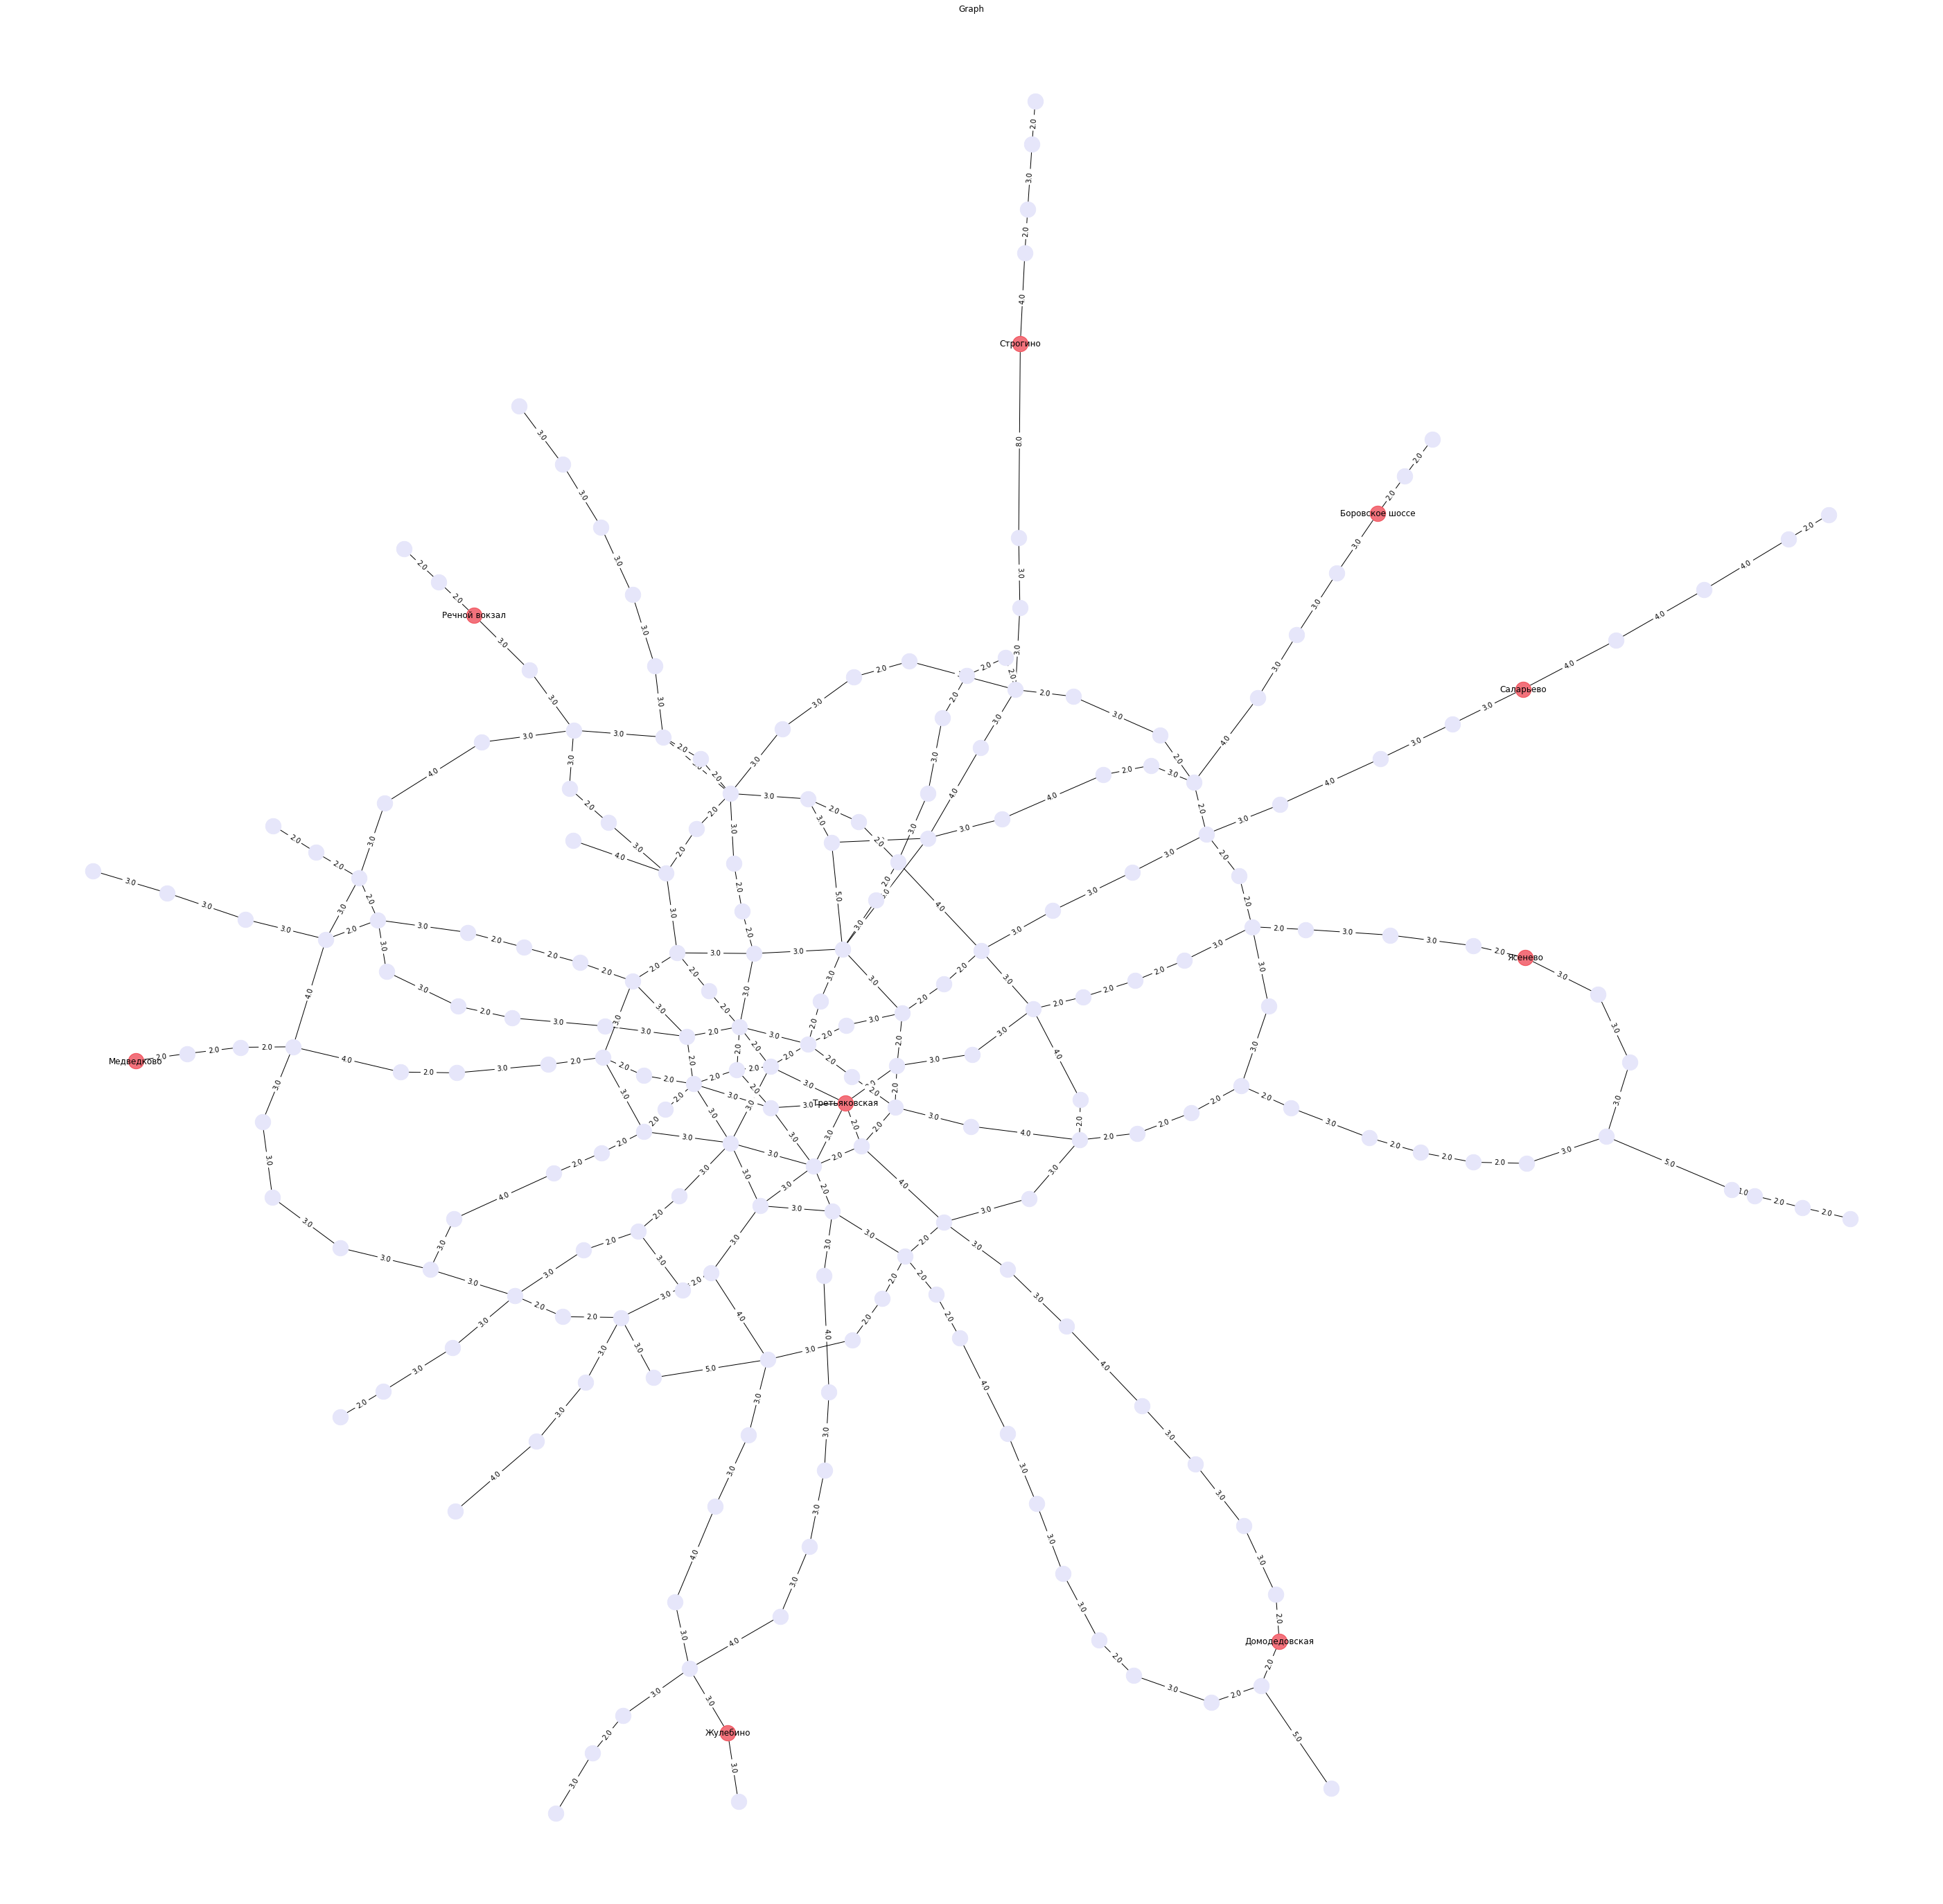

In [132]:
graph = nx.Graph()
create_nodes(graph, n)
create_edges(graph, m)
draw(graph,points)